In [1]:
import numpy as np
import matplotlib.pyplot as plt

# SPC retention (Eq. 11)
a1_spc, k1 = 0.1787, 0.5337
a2_spc, k2 = 0.8237, 0.00997

# Methane reference
GWP100_CH4 = 27.0
IRFint100 = 50.480844011106

# --- user choices
M_sink = 1.0      # tCO2e, for the TCE calculation
n = 20_000      # trapez number
H = 20                      # yr (user-defined horizon)
M_CH4 = 1.0                 # t CH4 (example methane emission)
M_sink_SPC_example = 1000.0 # tCO2e (example SPC sink pool)


In [2]:
## =========================================================
## Cell 2 – Constants and functions (SPC + IRF + integrals)
## =========================================================
## This cell defines:
## - SPC retention f_SPC(t)
## - CO2 impulse response IRF(t)
## - IRF integral IRF_int(H)
## - Kernel integral I(H) = ∫_0^H f_SPC(t)·IRF(t) dt (numeric + analytic)
## - TCE functions for CH4 and SPC
## - Eq. (22): required SPC sink mass
## - Eq. (23): methane offset potential of a given SPC sink pool


## -------------------------
## 1) SPC retention parameters (Eq. 11)
## -------------------------
a1_spc, k1 = 0.1787, 0.5337
a2_spc, k2 = 0.8237, 0.00997


## -------------------------
## 2) IRF parameters (Jeltsch–Thömmes & Joos, 2019)
## -------------------------
a0 = 0.008
a  = np.array([0.044, 0.112, 0.224, 0.310, 0.297], dtype=float)
tau = np.array([68521.0, 5312.0, 362.0, 47.0, 6.0], dtype=float)


## -------------------------
## 3) SPC retention function
## -------------------------
## Eq. (11): fraction of initial SPC sink mass remaining after t years
def f_SPC(t):
    t = np.asarray(t, dtype=float)
    return a1_spc*np.exp(-k1*t) + a2_spc*np.exp(-k2*t)


## -------------------------
## 4) CO2 impulse response function
## -------------------------
## IRF(t) = a0 + Σ a_i · exp(-t/τ_i)
def IRF(t):
    t = np.asarray(t, dtype=float)
    if t.ndim == 0:
        return a0 + np.sum(a*np.exp(-t/tau))
    return a0 + np.sum(a*np.exp(-t[:, None]/tau), axis=1)


## -------------------------
## 5) Analytic integral of IRF(t)
## -------------------------
## IRF_int(H) = ∫_0^H IRF(t) dt
def IRF_int(H):
    H = float(H)
    return a0*H + np.sum(a * tau * (1.0 - np.exp(-H/tau)))


## -------------------------
## 6) Kernel for diminishing SPC sink
## -------------------------
## Kernel y(t) = f_SPC(t) · IRF(t)
def y(t):
    return f_SPC(t) * IRF(t)


## -------------------------
## 7) Numerical trapezoid integral
## -------------------------
def trapz(yvals, xvals):
    yvals = np.asarray(yvals, dtype=float)
    xvals = np.asarray(xvals, dtype=float)
    return np.sum((yvals[1:] + yvals[:-1]) * 0.5 * (xvals[1:] - xvals[:-1]))


## -------------------------
## 8) Kernel integral I(H) = ∫_0^H f_SPC(t)·IRF(t) dt
## -------------------------
## Numeric integration (trapezoid) – used only as consistency check
def I_numeric(H, n=20_000):
    t = np.linspace(0.0, float(H), n+1)
    return trapz(y(t), t)

## Analytic integration – use this in the manuscript
def I_analytic(H):
    H = float(H)

    ## Constant IRF term a0
    const_part = a0 * (
        a1_spc*(1.0 - np.exp(-k1*H))/k1 +
        a2_spc*(1.0 - np.exp(-k2*H))/k2
    )

    ## Exponential IRF terms a_i · exp(-t/τ_i)
    exp_part = 0.0
    for ai, taui in zip(a, tau):
        lam = 1.0/taui
        exp_part += ai * (
            a1_spc*(1.0 - np.exp(-(k1 + lam)*H))/(k1 + lam) +
            a2_spc*(1.0 - np.exp(-(k2 + lam)*H))/(k2 + lam)
        )

    return const_part + exp_part


## -------------------------
## 9) TCE functions
## -------------------------
## Methane TCE over 100 years via GWP100(CH4):
## TCE_CH4_100 = M_CH4 · GWP100(CH4) · IRF_int(100)
def TCE_CH4_100(M_CH4, GWP100_CH4, IRFint100):
    return M_CH4 * GWP100_CH4 * IRFint100

## Diminishing SPC sink TCE over horizon H:
## TCE_SPC(H) = - M_sink · I(H)
def TCE_SPC(H, M_sink):
    return -M_sink * I_analytic(H)


## -------------------------
## 10) Eq. (22): Required SPC sink mass to offset methane
## -------------------------
## Solves:  TCE_CH4_100 + TCE_SPC(H, M_sink) = 0
def M_sink_required(H, M_CH4, GWP100_CH4, IRFint100):
    return TCE_CH4_100(M_CH4, GWP100_CH4, IRFint100) / I_analytic(H)


## -------------------------
## 11) Eq. (23): Methane offset by a given SPC sink pool
## -------------------------
## M_CH4-offset(H) = M_sink,SPC · I(H) / (GWP100(CH4) · IRF_int(100))
def M_CH4_offset(H, M_sink_SPC, GWP100_CH4, IRFint100):
    return (M_sink_SPC * I_analytic(H)) / (GWP100_CH4 * IRFint100)


In [5]:
## =========================================================
## Cell 3 – SPC calculations and printed results (Section 2.7.1)
## =========================================================
## This cell produces the numerical outputs used in the manuscript:
## (i) I(H) = ∫_0^H f_SPC(t) · IRF(t) dt
## (ii) Eq. (22): required SPC sink mass to offset a methane emission
## (iii) Eq. (23): methane mass that can be offset by a given SPC sink pool
## plus two short consistency checks.

## -------------------------
## 1) IRF integral 100
## -------------------------
IRFint100 = IRF_int(100.0)

## -------------------------
## 2) Kernel integral I(H)
## -------------------------
I_a = I_analytic(H)          # analytic integral (use for manuscript)
check_numeric = False
if check_numeric:
    I_n = I_numeric(H, n=n)
    print("\n--- Kernel integral check ---")
    print(f"I_analytic(H) = {I_a:.12f} yr   <-- use this")
    print(f"I_numeric(H)  = {I_n:.12f} yr   (n = {n})")
    print(f"|diff|        = {abs(I_n - I_a):.3e} yr")
## -------------------------
## 3) Methane reference TCE
## -------------------------
## TCE of methane emission (GWP100 method)
TCE_CH4 = TCE_CH4_100(M_CH4, GWP100_CH4, IRFint100)     # [tCO2e·yr]

## -------------------------
## 4) Eq. (22): required SPC sink mass
## -------------------------
## M_req is the certified SPC sink mass (tCO2e) needed to offset M_CH4 over horizon H
M_req = M_sink_required(H, M_CH4, GWP100_CH4,IRFint100)   # [tCO2e]

## Offset check: TCE_CH4 + TCE_SPC(M_req) should be ~0
TCE_total = TCE_CH4 + TCE_SPC(H, M_req)

## -------------------------
## 5) Eq. (23): methane offset by a given SPC pool
## -------------------------
M_CH4_off = M_CH4_offset(H, M_sink_SPC_example, GWP100_CH4, IRFint100)  # [tCH4]

## -------------------------
## 6) Remaining SPC pool after offset
## -------------------------
M_rem_example = M_sink_SPC_example * f_SPC(H)

## Inversion check: using M_req in Eq. (23) should recover M_CH4
M_CH4_check = M_CH4_offset(H, M_req, GWP100_CH4, IRFint100)

## -------------------------
## 6) Print key results (manuscript-ready)
## -------------------------
print("\n================ SPC case study – key results ================")
print(f"Horizon H                                : {H:.1f} yr")
print(f"I(H) = ∫_0^H f_SPC(t)·IRF(t) dt           : {I_a:.6f} yr")

print("\n--- Eq. (22): Required SPC sink mass to offset methane ---")
print(f"M_CH4 (given)                             : {M_CH4:.3f} t CH4")
print(f"GWP100(CH4)                               : {GWP100_CH4:.1f} tCO2e / tCH4")
print(f"M_sink,SPC required                        : {M_req:.3f} tCO2e")
print("TCE Methan", TCE_CH4)
print("\n--- Eq. (23): Methane offset by a given SPC sink pool ---")
print(f"M_sink,SPC (given)                         : {M_sink_SPC_example:.1f} tCO2e")
print(f"M_CH4-offset(H)                             : {M_CH4_off:.3f} t CH4")
print(f"\nRemaining SPC pool after {H:.1f} yr from initial sink pool of {M_sink_SPC_example} tCO2e : {M_rem_example:.3f} tCO2e")

print("\n--- Consistency checks ---")
print(f"TCE_CH4 + TCE_SPC(M_req)                   : {TCE_total:.3e} tCO2e·yr  (should be ~0)")
print(f"M_CH4-offset(H) from M_req                 : {M_CH4_check:.6f} t CH4  (should match {M_CH4} t CH4)")
print("==============================================================\n")



================ SPC case study – key results ================
Horizon H                                : 20.0 yr
I(H) = ∫_0^H f_SPC(t)·IRF(t) dt           : 11.151239 yr

--- Eq. (22): Required SPC sink mass to offset methane ---
M_CH4 (given)                             : 1.000 t CH4
GWP100(CH4)                               : 27.0 tCO2e / tCH4
M_sink,SPC required                        : 122.227 tCO2e
TCE Methan 1362.9827882998688

--- Eq. (23): Methane offset by a given SPC sink pool ---
M_sink,SPC (given)                         : 1000.0 tCO2e
M_CH4-offset(H)                             : 8.181 t CH4

Remaining SPC pool after 20.0 yr from initial sink pool of 1000.0 tCO2e : 674.797 tCO2e

--- Consistency checks ---
TCE_CH4 + TCE_SPC(M_req)                   : 0.000e+00 tCO2e·yr  (should be ~0)
M_CH4-offset(H) from M_req                 : 1.000000 t CH4  (should match 1.0 t CH4)



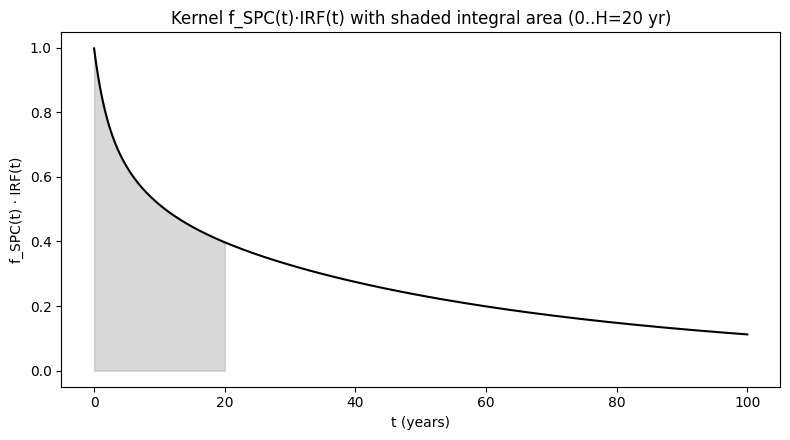

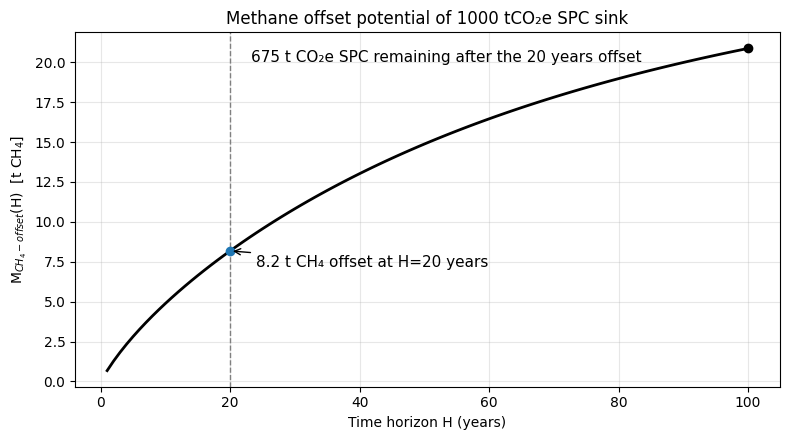

In [4]:
#Graphics
# force white background + black text for this plot
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "black",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "text.color": "black"
})
tmax = 100
dt = 0.1

t = np.arange(0.0, tmax + dt, dt)
yvals = y(t)
mask = (t <= H)

plt.figure(figsize=(8, 4.5))
plt.plot(t, yvals, color="black")
plt.fill_between(t[mask], 0, yvals[mask], color="grey", alpha=0.3)
plt.xlabel("t (years)")
plt.ylabel("f_SPC(t) · IRF(t)")
plt.title(f"Kernel f_SPC(t)·IRF(t) with shaded integral area (0..H={H} yr)")
plt.tight_layout()
plt.show()

## =========================================================
## Figure: CH4 offset potential of a given SPC pool
## =========================================================
## This figure shows how much methane can be offset by a fixed SPC pool
## (e.g., 1000 tCO2e of SPC biochar) depending on the chosen time horizon H.

## Horizon range for plotting
H_vals = np.arange(1, 101, 1)   # 1..100 years

## Compute IRF_int(100) from IRF definition
IRFint100 = IRF_int(100.0)

## Compute methane offset for each horizon
M_CH4_offset_vals = np.array([
    M_CH4_offset(Hh, M_sink_SPC_example, GWP100_CH4, IRFint100) for Hh in H_vals
])

## Value at H = 20 yr and 100 yr (for marker)
H_mark = 20
M_mark = M_CH4_offset(H_mark, M_sink_SPC_example, GWP100_CH4, IRFint100)
End_mark = 100
M_end = M_CH4_offset(End_mark, M_sink_SPC_example, GWP100_CH4, IRFint100)

## Plot
fig5 = plt.figure(figsize=(8, 4.5))
plt.plot(H_vals, M_CH4_offset_vals, color="black", linewidth=2)

plt.xlabel("Time horizon H (years)")
plt.ylabel(r"M$_{CH_4-offset}$(H)  [t CH$_4$]")
plt.title(f"Methane offset potential of {M_sink_SPC_example:.0f} tCO₂e SPC sink")

plt.grid(True, alpha=0.3)

## Vertical dashed line at H = 20 years
plt.axvline(x=20, linestyle="--", color="grey", linewidth=1)

## Marker at H = 20 and at H = 100
plt.scatter([H_mark], [M_mark], zorder=3)
plt.scatter([End_mark], [M_end], color="black", zorder=3)

## --- Annotation at H = 20 (offset value)
plt.annotate(f"{M_mark:.1f} t CH₄ offset at H=20 years",
             xy=(H_mark, M_mark),
             xytext=(H_mark + 4, M_mark - 1.0),
             arrowprops=dict(arrowstyle="->", lw=1),
             fontsize=11)

## --- Callout: remaining SPC mass after H = 20 years
M_remaining_20 = M_sink_SPC_example * f_SPC(H_mark)

## Text box in the top-left corner (axes coordinates)
plt.annotate(f"{M_remaining_20:.0f} t CO₂e SPC remaining after the 20 years offset",
             xy=(0.25, 0.95), xycoords="axes fraction",
             fontsize=11,
             ha="left", va="top")


plt.tight_layout()
fig5.savefig("../figures/figure_SPC-CH4_offset.jpg", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

